# Advanced Credit Card Fraud Detection using RNN

This notebook implements an advanced credit card fraud detection system using Recurrent Neural Networks (RNN) with TensorFlow. We'll use LSTM layers to capture sequential patterns in credit card transactions and build a robust fraud detection model.

In [1]:
!pip install imblearn numpy scikit-learn pandas matplotlib seaborn pickle keras tensorflow

ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle


## 1. Import Required Libraries

Let's import all the necessary libraries for our project:

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import warnings
warnings.filterwarnings('ignore')

## 2. Data Loading and Preprocessing

Let's load the credit card fraud dataset and perform initial preprocessing:

In [ ]:
# Load the dataset
df = pd.read_csv('/data/creditcard.csv')

# Check for missing values
print("Missing values:\n", df.isnull().sum())

# Display basic information about the dataset
print("\nDataset Info:")
print(df.info())

# Display class distribution
print("\nClass distribution:")
print(df['Class'].value_counts(normalize=True))

# Separate features and target
X = df.drop('Class', axis=1)
y = df['Class']

# Create sequences for RNN (using time steps of 3)
def create_sequences(X, y, time_steps=3):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X.iloc[i:(i + time_steps)].values)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Create sequences
X_seq, y_seq = create_sequences(X_scaled, y)

print("\nSequence shape:", X_seq.shape)
print("Target shape:", y_seq.shape)

Missing values:
 Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284

## 3. Exploratory Data Analysis

Let's analyze the data distribution and handle class imbalance:

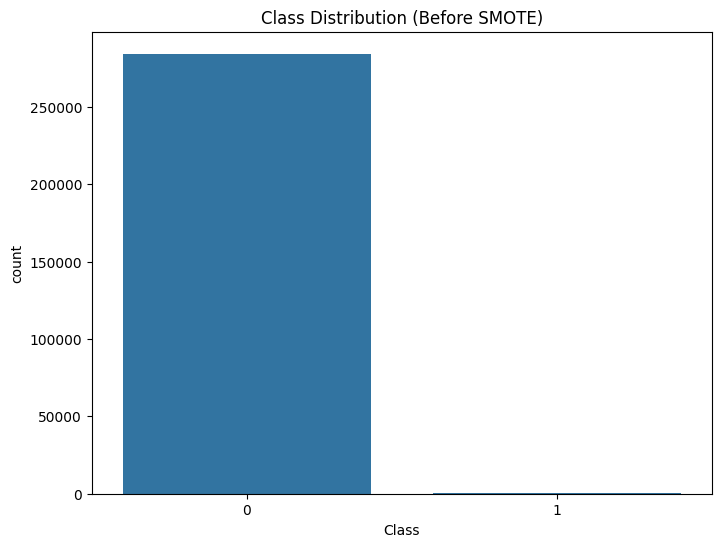

Original shape: (284804, 3, 30)
Resampled shape: (568624, 3, 30)


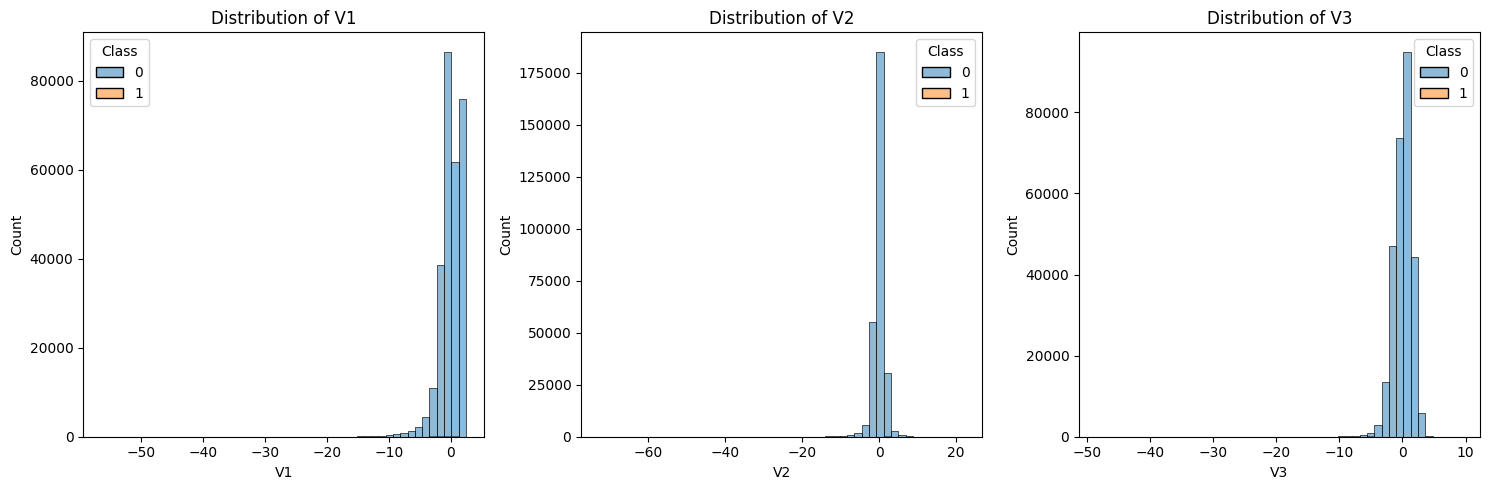

In [4]:
# Visualize class distribution
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='Class')
plt.title('Class Distribution (Before SMOTE)')
plt.show()

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_seq_reshaped = X_seq.reshape(X_seq.shape[0], -1)
X_resampled, y_resampled = smote.fit_resample(X_seq_reshaped, y_seq)
X_resampled = X_resampled.reshape(-1, X_seq.shape[1], X_seq.shape[2])

print("Original shape:", X_seq.shape)
print("Resampled shape:", X_resampled.shape)

# Visualize feature distributions
plt.figure(figsize=(15, 5))
for i in range(3):
    plt.subplot(1, 3, i+1)
    sns.histplot(data=df, x=f'V{i+1}', hue='Class', bins=50)
    plt.title(f'Distribution of V{i+1}')
plt.tight_layout()
plt.show()

## 4. Building RNN Model

Let's create our advanced RNN model using LSTM layers:

In [5]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Build the advanced RNN model with 6 hidden layers
model = Sequential([
    # 1st LSTM layer with tanh activation (default for LSTM)
    LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    Dropout(0.3),

    # 2nd LSTM layer with tanh activation
    LSTM(96, return_sequences=True),
    Dropout(0.3),

    # 3rd LSTM layer with tanh activation
    LSTM(64, return_sequences=True),
    Dropout(0.3),

    # 4th LSTM layer with tanh activation
    LSTM(48, return_sequences=True),
    Dropout(0.3),

    # 5th LSTM layer with tanh activation
    LSTM(32, return_sequences=True),
    Dropout(0.3),

    # 6th LSTM layer
    LSTM(24, return_sequences=False),
    Dropout(0.3),

    # Dense layers with different activation functions
    Dense(64, activation='relu'),  # ReLU activation
    Dense(48, activation='elu'),   # ELU activation
    Dense(32, activation='selu'),  # SELU activation
    Dense(24, activation='tanh'),  # Tanh activation
    Dense(16, activation='swish'), # Swish activation
    Dense(8, activation='sigmoid'), # Sigmoid activation

    # Output layer
    Dense(1, activation='softmax')
])

# Compile the model with binary crossentropy loss
model.compile(optimizer='adam',
              loss='binary_crossentropy',  # Binary classification loss function
              metrics=['accuracy', tf.keras.metrics.AUC(),
                      tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall()])

# Display model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 3, 128)         │        81,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 3, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 3, 96)          │        86,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 3, 96)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 3, 64)          │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 3, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 3, 48)          │        21,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 3, 48)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 3, 32)          │        10,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 3, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 24)             │         5,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         1,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 48)             │         3,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 24)             │           792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 254,185 (992.91 KB)

 Trainable params: 254,185 (992.91 KB)

 Non-trainable params: 0 (0.00 B)

## 5. Model Training

Let's train our model with early stopping to prevent overfitting:

Epoch 1/20
10704/10704 ━━━━━━━━━━━━━━━━━━━━ 320s 28ms/step - accuracy: 0.5012 - auc: 0.5000 - loss: 0.2871 - precision: 0.5012 - recall: 1.0000 - val_accuracy: 0.4988 - val_auc: 0.5000 - val_loss: 0.0158 - val_precision: 0.4988 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/20
10704/10704 ━━━━━━━━━━━━━━━━━━━━ 292s 26ms/step - accuracy: 0.4992 - auc: 0.5000 - loss: 0.0203 - precision: 0.4992 - recall: 1.0000 - val_accuracy: 0.4988 - val_auc: 0.5000 - val_loss: 0.0084 - val_precision: 0.4988 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/20
10704/10704 ━━━━━━━━━━━━━━━━━━━━ 318s 25ms/step - accuracy: 0.4990 - auc: 0.5000 - loss: 0.0106 - precision: 0.4990 - recall: 1.0000 - val_accuracy: 0.4988 - val_auc: 0.5000 - val_loss: 0.0045 - val_precision: 0.4988 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 4/20
10704/10704 ━━━━━━━━━━━━━━━━━━━━ 324s 25ms/step - accuracy: 0.5009 - auc: 0.5000 - loss: 0.0077 - precision: 0.5009 - recall: 1.0000 - val_accuracy: 0.4988 - val_auc: 0.5

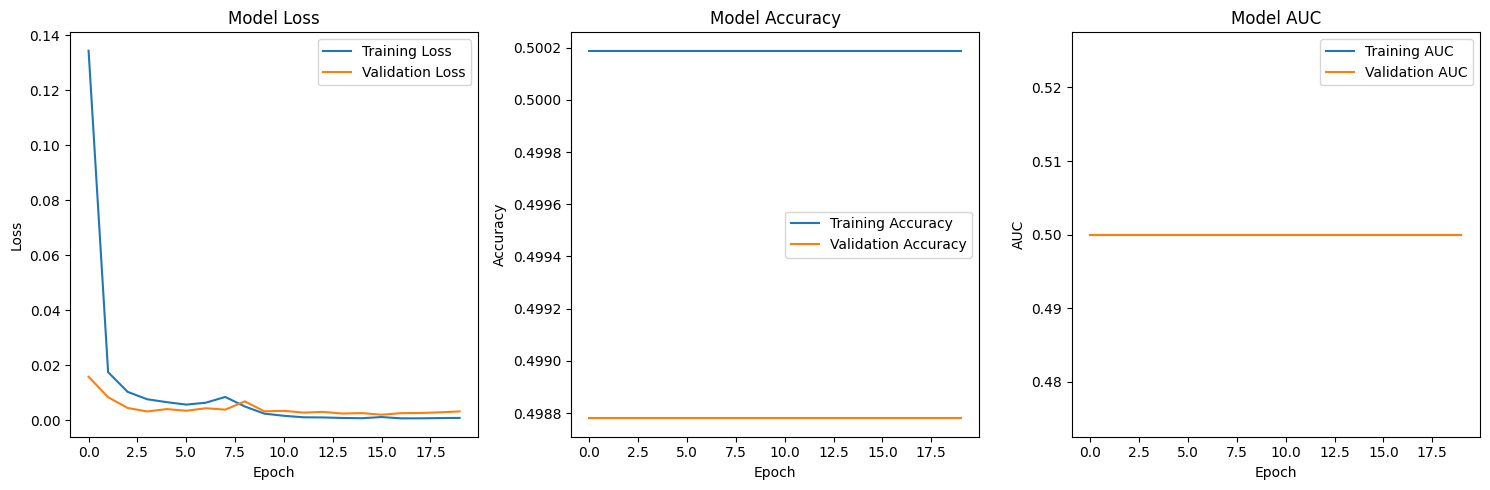

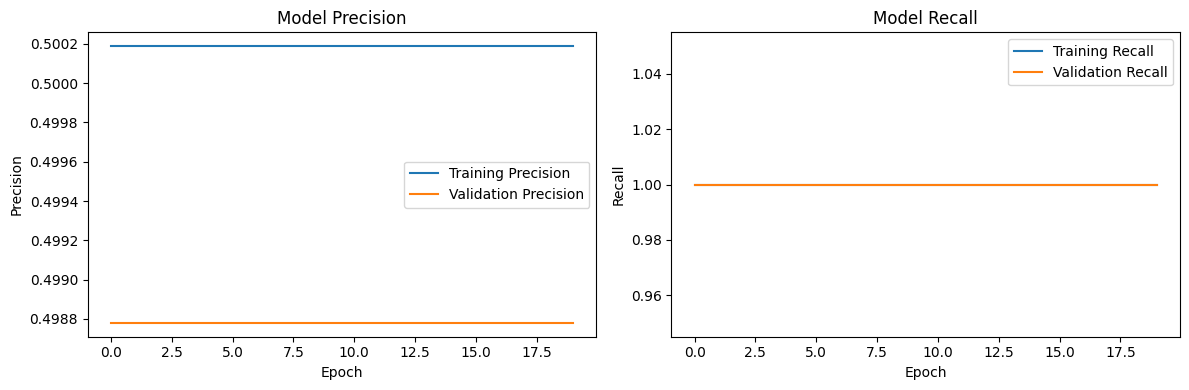

In [6]:
# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.00001
)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=20,  # Increased epochs for complex model
    batch_size=34,  # Adjusted batch size
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr]
)

# Plot training history
plt.figure(figsize=(15, 5))

# Plot loss
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 3, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot AUC
plt.subplot(1, 3, 3)
plt.plot(history.history['auc'], label='Training AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.title('Model AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()

plt.tight_layout()
plt.show()

# Plot additional metrics
plt.figure(figsize=(12, 4))

# Plot Precision
plt.subplot(1, 2, 1)
plt.plot(history.history['precision'], label='Training Precision')
plt.plot(history.history['val_precision'], label='Validation Precision')
plt.title('Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

# Plot Recall
plt.subplot(1, 2, 2)
plt.plot(history.history['recall'], label='Training Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.title('Model Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

plt.tight_layout()
plt.show()

## 6. Model Evaluation

Let's evaluate our model's performance using various metrics:

3554/3554 ━━━━━━━━━━━━━━━━━━━━ 25s 7ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     56820
           1       0.50      1.00      0.67     56905

    accuracy                           0.50    113725
   macro avg       0.25      0.50      0.33    113725
weighted avg       0.25      0.50      0.33    113725



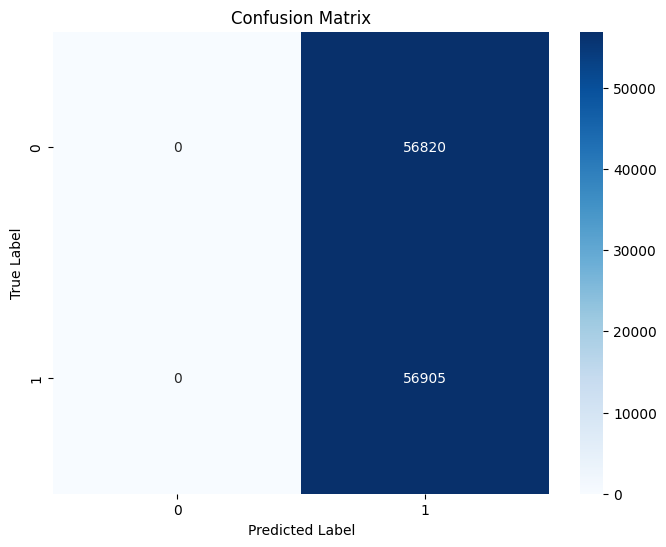

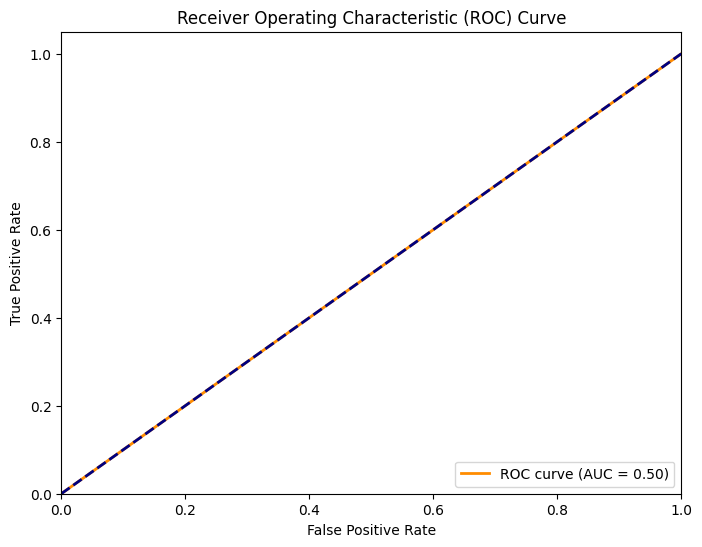

In [7]:
# Make predictions
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_classes))

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Calculate ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## 7. Save and Load Model

Let's save our trained model for future use:

In [ ]:
# Save the model and scaler
model.save('/model/fraud_detection_model.h5')
with open('/model/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("Model and scaler saved successfully!")

# Function to load the model and scaler
def load_model_and_scaler():
    loaded_model = tf.keras.models.load_model('/model/fraud_detection_model.h5')
    with open('/model/scaler.pkl', 'rb') as f:
        loaded_scaler = pickle.load(f)
    return loaded_model, loaded_scaler

# Test loading
loaded_model, loaded_scaler = load_model_and_scaler()
print("Model and scaler loaded successfully!")

Model and scaler saved successfully!


Model and scaler loaded successfully!


## 8. Real-time Prediction

Let's create a function for real-time fraud detection:

In [9]:
def predict_fraud(transaction_data, model, scaler, time_steps=3):
    """
    Predict if a transaction is fraudulent

    Parameters:
    transaction_data: numpy array of shape (30,) containing the transaction features
    model: loaded keras model
    scaler: loaded StandardScaler
    time_steps: number of time steps used in training

    Returns:
    probability of fraud, prediction (0: legitimate, 1: fraud)
    """
    # Scale the transaction
    scaled_transaction = scaler.transform(transaction_data.reshape(1, -1))

    # Create sequence (assuming we have previous transactions)
    # For demo, we'll just repeat the same transaction
    sequence = np.repeat(scaled_transaction, time_steps, axis=0)
    sequence = sequence.reshape(1, time_steps, -1)

    # Make prediction
    fraud_probability = model.predict(sequence)[0][0]
    fraud_prediction = 1 if fraud_probability > 0.5 else 0

    return fraud_probability, fraud_prediction

# Test the function with a sample transaction
sample_transaction = X.iloc[0].values
prob, pred = predict_fraud(sample_transaction, loaded_model, loaded_scaler)

print(f"Fraud Probability: {prob:.2%}")
print(f"Prediction: {'Fraudulent' if pred == 1 else 'Legitimate'} Transaction")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Fraud Probability: 100.00%
Prediction: Fraudulent Transaction
